In [82]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import torch as th
import cv2 
import csv
#from os import path as path
import time
import h5py
import copy

#for dataloader
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataset import Dataset

from google.colab import drive
drive.mount('/content/drive')

# Part 1: Data Loading & Demographics

In [83]:
def load_mat(data_file_loc):
    curr_store = sio.loadmat(data_file_loc)
    curr_data = curr_store['FaceRho'].transpose()
    return curr_data

def get_demographics(df_data_info,inds):
    #df_data_subset = df_data_info[df_data_info['case_num'].isin(file_nums)]
    df_data_subset = df_data_info.iloc[inds]
    
    labels = df_data_subset['sex']
    ages = df_data_subset['age']

    mean_age = np.mean(ages)
    M_ratio = np.sum(labels=='M')/len(labels)*100
    F_ratio = np.sum(labels=='F')/len(labels)*100
    MF_ratio = np.sum(labels=='F')/np.sum(labels=='M')

    
    print(f"total cases: {len(labels)}")
    print(f"average age: {mean_age:.2f} +- {np.std(ages):.2f} std")
    print(f"males: {M_ratio:.2f}%")
    print(f"females: {F_ratio:.2f}%")
    print(f"F/M ratio: {MF_ratio:.4f}")


In [84]:
#define filepaths
filepath_data = '/data/VirtualAging/users/mwtong/FaceBoneGender/data'
filename_info = '/data/VirtualAging/users/mwtong/FaceBoneGender/FaceBoneGenderStudy_noMissing_clean_v2.csv' #location of .csv file
#filepath_splits = '/data/VirtualAging/users/mwtong/FaceBoneGender/splits'
filepath_models = '/data/VirtualAging/users/mwtong/FaceBoneGender/models'

#filename_info = '/content/drive/MyDrive/cs182_project_copy/FaceBoneGenderStudy_noMissing_clean.csv' #location of .csv file
#filepath_splits = '/content/drive/MyDrive/cs182_project_copy'
#filepath_models = '/content/drive/MyDrive/cs182_project_copy'

#load study csv file
df_data_info = pd.read_csv(filename_info)
df_data_info = df_data_info[df_data_info['imgs_exist'] == 1]
df_data_info = df_data_info[df_data_info['keep_image'] == 1]
df_data_info = df_data_info.reset_index()

#look at study demographics
print('---train data demographics---')
get_demographics(df_data_info,list(range(len(df_data_info))))

df_data_info

---train data demographics---
total cases: 1026
average age: 54.02 +- 25.87 std
males: 66.86%
females: 32.85%
F/M ratio: 0.4913


,level_0,index,case_num,dcm_path,exists,sphEncode_img,sex,PID,age,sex_label,imgs_exist,keep_image,max_intensity,min_intensity
0,0,0,1,/data/VirtualAging/FaceBoneSurface/00ZX1deCFm/...,1,/data/VirtualAging/users/mwtong/FaceBoneGender...,F,00ZX1deCFm,24,1,1,1,215.37,0
1,1,1,2,/data/VirtualAging/FaceBoneSurface/03eDr8idyA/...,1,/data/VirtualAging/users/mwtong/FaceBoneGender...,M,03eDr8idyA,35,0,1,1,216.01,0
2,2,2,3,/data/VirtualAging/FaceBoneSurface/03sELtXkRr/...,1,/data/VirtualAging/users/mwtong/FaceBoneGender...,M,03sELtXkRr,59,0,1,1,245.66,0
3,3,3,4,/data/VirtualAging/FaceBoneSurface/04ScRnuBZa/...,1,/data/VirtualAging/users/mwtong/FaceBoneGender...,F,04ScRnuBZa,55,1,1,1,201.63,0
4,4,4,5,/data/VirtualAging/FaceBoneSurface/0DeSNo4jk1/...,1,/data/VirtualAging/users/mwtong/FaceBoneGender...,M,0DeSNo4jk1,33,0,1,1,207.89,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1021,1317,1317,1357,/data/VirtualAging/FaceBoneSurface/zeasNnOQ5I/...,1,/data/VirtualAging/users/mwtong/FaceBoneGender...,M,zeasNnOQ5I,42,0,1,1,204.40,0
1022,1318,1318,1358,/data/VirtualAging/FaceBoneSurface/zfbaNKzj15/...,1,/data/VirtualAging/users/mwtong/FaceBoneGender...,M,zfbaNKzj15,118,0,1,1,198.52,0
1023,1319,1319,1359,/data/VirtualAging/FaceBoneSurface/zh1zk7F8J3/...,1,/data/VirtualAging/users/mwtong/FaceBoneGender...,F,zh1zk7F8J3,53,1,1,1,207.06,0
1024,1320,1320,1360,/data/VirtualAging/FaceBoneSurface/zieo7ZM5pW/...,1,/data/VirtualAging/users/mwtong/FaceBoneGender...,M,zieo7ZM5pW,55,0,1,1,208.53,0


/data/VirtualAging/users/mwtong/FaceBoneGender/data/0002.mat


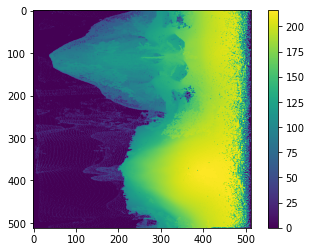

In [85]:
test = sio.loadmat(filepath_data + '/0002.mat')
data = test['FaceRho']

print(filepath_data + '/0002.mat')
plt.imshow(data)
plt.colorbar()

In [86]:
'''
#Load data - images and labels
file_nums = []
images = []
labels = []

for row in range(len(df_data_info)):
    # extract the mat filename and label
    data_file_loc = filepath_data+'/'+df_data_info['sphEncode_img'][row][-8:]
    label = int(df_data_info['sex_label'][row])
    img_num = int(df_data_info['sphEncode_img'][row][-8:-4])
    
    try:
        #load the image into a numpy array and convert to a pytorch tensor
        #The None dimension adds an axis so the shape changes from 512x512 to 1x512x512
        curr_data = load_mat(data_file_loc)
        curr_data = th.from_numpy(curr_data[None,:,:]).float()
        
        #save data in a pytorch tensor
        images.append(curr_data)
        labels.append(label)
        file_nums.append(img_num)
    except FileNotFoundError:
        print("Data Point #" + str(row) + " does not exist")

#turning the list of tensors into a single tensor
stacked_images = th.stack(images, axis=0)
stacked_labels = th.FloatTensor(labels)[:,None]
stacked_file_nums = th.tensor(file_nums)
print(stacked_images.shape)
print(stacked_labels.shape)
print(stacked_file_nums.shape)

dataset = th.utils.data.TensorDataset(stacked_images, stacked_labels, stacked_file_nums)
'''

'\n#Load data - images and labels\nfile_nums = []\nimages = []\nlabels = []\n\nfor row in range(len(df_data_info)):\n    # extract the mat filename and label\n    data_file_loc = filepath_data+\'/\'+df_data_info[\'sphEncode_img\'][row][-8:]\n    label = int(df_data_info[\'sex_label\'][row])\n    img_num = int(df_data_info[\'sphEncode_img\'][row][-8:-4])\n    \n    try:\n        #load the image into a numpy array and convert to a pytorch tensor\n        #The None dimension adds an axis so the shape changes from 512x512 to 1x512x512\n        curr_data = load_mat(data_file_loc)\n        curr_data = th.from_numpy(curr_data[None,:,:]).float()\n        \n        #save data in a pytorch tensor\n        images.append(curr_data)\n        labels.append(label)\n        file_nums.append(img_num)\n    except FileNotFoundError:\n        print("Data Point #" + str(row) + " does not exist")\n\n#turning the list of tensors into a single tensor\nstacked_images = th.stack(images, axis=0)\nstacked_labels 

In [100]:
class face_img_dataloader(Dataset):
    def __init__(self, df_data_info, filepath_data, transform=None, scale=False):
        self.df_data_info = df_data_info
        self.filepath_data = filepath_data
        self.labels = self.df_data_info['sex_label'].values
        self.age = self.df_data_info['age']
        self.file_nums = self.df_data_info['case_num'].tolist()
        self.data_filepath = filepath_data
        self.transform = transform
        self.scale = scale
    def __getitem__(self, row):
        # This method should return only 1 sample and label (according to "row" of dataframe),
        # not the whole dataset
        
        data_file_loc = self.filepath_data+'/'+self.df_data_info['sphEncode_img'][row][-8:]
        label = th.FloatTensor(self.labels[row,None])
        file_num = int(self.df_data_info['sphEncode_img'][row][-8:-4])

        try:
            #load the image into a numpy array and convert to a pytorch tensor
            #The None dimension adds an axis so the shape changes from 512x512 to 1x512x512
            image = load_mat(data_file_loc)
            image = th.from_numpy(image[None,:,:]).float()
            
            #if images are different sizes
            #image = np.asarray(image).reshape(self.width, self.height)
            #image = cv2.resize(image.astype('uint8'), (self.width, self.height))
        
            if self.scale is True:
                image = image/th.max(image)
            if self.transform is not None:
                image = self.transform(image)
        except:
            print('error loading data row '+str(row))
            
        return image, label, file_num

    def __len__(self):
        return len(self.labels)
    
    def __getitem_fromfilenum__(self,file_num):
        row = self.file_nums.index(file_num)
        image, label, file_num = self.__getitem__(row)
        return image, label, file_num

In [101]:
def plot_images(img_num_list,dataset,filepath_data='',filename_info=''):
    #inputs depend on how we load the data
    '''
    df_data_info = pd.read_csv(filename_info)
    img_file_nums = df_data_info['case_num'].tolist()
    
    df_data_info = pd.read_csv(filename_info)
    '''
    
    #Visualize images
    fig = plt.figure(figsize=(18,6))
    ax = plt.gca()
    
    print('figure of files ', img_num_list)
    for ii in range(len(img_num_list)):
        img_num = img_num_list[ii]
        
        '''
        #load data from files
        if False:
            file_name = f"{filepath_data}/{img_num:04d}.mat"
            data = load_mat(file_name)
            print(file_name)
        #load data from np arrays
        elif False:
            img_loc = img_file_nums.index(img_num)
            data = np.array(images[img_loc][0,:,:])
            label = labels[img_loc]
            if label == 0: 
                label_text = 'male'
            elif label == 1:
                label_text = 'female'
        '''
        #load data from dataloader class variable
        image, label, file_num = dataset.__getitem_fromfilenum__(img_num)
        data = np.array(image[0,:,:])
        if label == 0: 
            label_text = 'male'
        elif label == 1:
            label_text = 'female'

        #plot images
        plt.subplot(1,3,ii+1)
        im = plt.imshow(data,cmap='turbo')
        plt.clim(0,np.max(data))
        plt.axis('off')
        plt.title(f'{label_text}, file_num {file_num}')

    fig.subplots_adjust(right=0.83)
    cbar_ax = fig.add_axes([0.85,0.15,0.01,0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)

In [105]:
# Split data into train, validation, and testing
# Up to this point, both methods define a dataloader

#define split parameters here
train_split = 0.8
validation_split = 0.1
test_split = 0.1

batch_size = 16
shuffle_dataset = True
shuffle_model_input = True
random_seed= 42
transforms_ = None
#th.manual_seed(random_seed)
#transforms_ = transforms.Compose([
#    transforms.RandomRotation(degrees=(0,180))
#    ])
scale_0to1 = True

#Use the dataloader to define the dataset class
dataset = face_img_dataloader(df_data_info,filepath_data, transform=transforms_,scale=scale_0to1)

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
print('Check if dataset matches dataframe: ',dataset_size,'=',len(df_data_info['case_num'].tolist()))
n_train = int(np.floor(train_split * dataset_size))
n_val = int(np.floor(validation_split * dataset_size))
n_test = dataset_size - n_train - n_val

if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, val_indices, test_indices = indices[:n_train], indices[n_train:(n_train+n_val)], indices[-n_test:]

# Check data demographics
print('---all data demographics---')
get_demographics(df_data_info,indices)
print(f'\n---train data demographics---')
get_demographics(df_data_info,train_indices)
print(f'\n---val data demographics---')
get_demographics(df_data_info,val_indices)
print(f'\n---test data demographics---')
get_demographics(df_data_info,test_indices)
print()

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

# randomly sample from these subset of indices, in the DataLoader if shuffle- True then the dataloader
# will initialize a Random Sampler for you, other it will use sequential sampler
train_loader = th.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = th.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)
test_loader = th.utils.data.DataLoader(dataset, batch_size=1, shuffle = False, sampler=test_sampler)

#datasets with no transforms
dataset_test_no_transforms = face_img_dataloader(df_data_info.iloc[test_indices],filepath_data, transform=None)
test_loader_no_transforms = th.utils.data.DataLoader(dataset_test_no_transforms, batch_size=1, shuffle = False)

Check if dataset matches dataframe:  1026 = 1026
---all data demographics---
total cases: 1026
average age: 54.02 +- 25.87 std
males: 66.86%
females: 32.85%
F/M ratio: 0.4913

---train data demographics---
total cases: 820
average age: 54.64 +- 26.59 std
males: 65.61%
females: 34.02%
F/M ratio: 0.5186

---val data demographics---
total cases: 102
average age: 50.81 +- 25.07 std
males: 73.53%
females: 26.47%
F/M ratio: 0.3600

---test data demographics---
total cases: 104
average age: 52.30 +- 19.85 std
males: 70.19%
females: 29.81%
F/M ratio: 0.4247



In [106]:
'''
"""This section is to split the data without the data loader """
#Dividing the Dataset into Training and Testing Datasets. 
#Define the random seed for reproducability. The first time a random seed is used the data will be split and
#saved, afterwards the data will be loaded from the .pt file.

#define split parameters here
train_split = 0.8
validation_split = 0.1
test_split = 0.1

batch_size = 16
shuffle_dataset = True
shuffle_model_input = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
n_train = int(np.floor(train_split * dataset_size))
n_val = int(np.floor(validation_split * dataset_size))
n_test = dataset_size - n_train - n_val

# Split data and save in a pytorch file (.pt)
filename_traindata = filepath_splits+f'/seed{random_seed:d}_dataset_train.pt'
filename_valdata = filepath_splits+f'/seed{random_seed:d}_dataset_val.pt'
filename_testdata = filepath_splits+f'/seed{random_seed:d}_dataset_test.pt'

th.manual_seed(random_seed)
dataset_train, dataset_val, dataset_test = th.utils.data.random_split(
    dataset, [n_train, n_val, n_test], generator=th.Generator().manual_seed(random_seed))


th.save(dataset_train, filename_traindata) #saves the dataset_train to location
th.save(dataset_val, filename_valdata) #saves the dataset_test to location
th.save(dataset_test, filename_testdata) #saves the dataset_test to location
print('saved train, val, and test data')


print(f'num train={len(dataset_train)}, {filename_traindata}')
print(f'num val={len(dataset_val)},    {filename_valdata}')
print(f'num test={len(dataset_test)},   {filename_testdata}')


dataset_train_loader = th.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=shuffle_model_input)
dataset_val_loader = th.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=shuffle_model_input)
dataset_test_loader = th.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

'''

'\n"""This section is to split the data without the data loader """\n#Dividing the Dataset into Training and Testing Datasets. \n#Define the random seed for reproducability. The first time a random seed is used the data will be split and\n#saved, afterwards the data will be loaded from the .pt file.\n\n#define split parameters here\ntrain_split = 0.8\nvalidation_split = 0.1\ntest_split = 0.1\n\nbatch_size = 16\nshuffle_dataset = True\nshuffle_model_input = True\nrandom_seed= 42\n\n# Creating data indices for training and validation splits:\ndataset_size = len(dataset)\nindices = list(range(dataset_size))\nn_train = int(np.floor(train_split * dataset_size))\nn_val = int(np.floor(validation_split * dataset_size))\nn_test = dataset_size - n_train - n_val\n\n# Split data and save in a pytorch file (.pt)\nfilename_traindata = filepath_splits+f\'/seed{random_seed:d}_dataset_train.pt\'\nfilename_valdata = filepath_splits+f\'/seed{random_seed:d}_dataset_val.pt\'\nfilename_testdata = filepath_s

figure of files  [16, 5, 700]


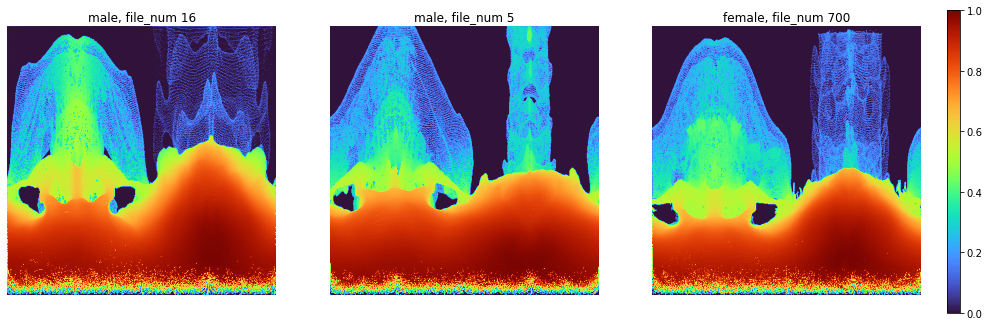

In [107]:
#specify the file number for the image, ie. 2 for 0002.mat
img_num_list = [16,5,700] # 16,5,700 --> 18,5,877
plot_images(img_num_list,dataset=dataset)

# 2. Network Architecture

**Architecture - DN default & pretrained**

In [ ]:
# Save the model if it does not exist, or load existing model
model_architecture_txt = 'DN_pretrained_k7' # 'a_DN_default' or 'b_DN_pretrained'
filename_model_network = filepath_models+f'/model_{model_architecture_txt}.pth'
print(filename_model_network)

#DenseNet Based Models
model_densenet_num = th.hub.load('pytorch/vision:v0.10.0', 'densenet201', pretrained=True)
# if want pretrained weights="IMAGENET1K_V1"

#removes the last layer from the pretrained model
model_densenet_num.classifier = th.nn.Sequential(
    th.nn.Linear(1920, 1000, bias=True),
    th.nn.ReLU(inplace=True),

    th.nn.Linear(1000, 500, bias=True), 
    th.nn.ReLU(inplace=True),

    th.nn.Linear(500, 1, bias=True), 
    th.nn.Sigmoid()
)

model_densenet_num = th.nn.Sequential(
    #3x512x512
    th.nn.Conv2d(1, 3, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1)), #Conv Layer
    th.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #Norm
    th.nn.ReLU(inplace=True), #ReLU

    th.nn.Conv2d(3, 3, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1)), #Conv Layer
    th.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #Norm
    th.nn.ReLU(inplace=True), #ReLU

    th.nn.Conv2d(3, 3, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1)), #Conv Layer
    th.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #Norm
    th.nn.ReLU(inplace=True), #ReLU

    #3x256x256
    th.nn.Conv2d(3, 3, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1)), #Conv Layer
    th.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #Norm
    th.nn.ReLU(inplace=True), #ReLU

    th.nn.Conv2d(3, 3, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1)), #Conv Layer
    th.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #Norm
    th.nn.ReLU(inplace=True), #ReLU

    th.nn.Conv2d(3, 3, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1)), #Conv Layer
    th.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #Norm
    th.nn.ReLU(inplace=True), #ReLU

    #do not mess around with these layers 
    #3x248x248
    th.nn.Conv2d(3, 3, kernel_size=(9, 9), stride=(1, 1), padding=(0, 0)), #Conv Layer
    th.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #Norm
    th.nn.ReLU(inplace=True), #ReLU

    #3x240x240
    th.nn.Conv2d(3, 3, kernel_size=(9, 9), stride=(1, 1), padding=(0, 0)), #Conv Layer
    th.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #Norm
    th.nn.ReLU(inplace=True), #ReLU

    #3x232x232
    th.nn.Conv2d(3, 3, kernel_size=(9, 9), stride=(1, 1), padding=(0, 0)), #Conv Layer
    th.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #Norm
    th.nn.ReLU(inplace=True), #ReLU

    #3x224x224
    th.nn.Conv2d(3, 3, kernel_size=(9, 9), stride=(1, 1), padding=(0, 0)), #Conv Layer
    th.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #Norm
    th.nn.ReLU(inplace=True), #ReLU

    model_densenet_num
)
print(model_densenet_num)

#test whether model runs
print('test if model works')
model = copy.deepcopy(model_densenet_num)
model.eval() #turns the model into evaluation mode so the weights are not effected by the testing
iterator=iter(val_loader)
for ii in range(1):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels, file_num = next(iterator)
    #inputs, labels = inputs.to(torch_device), labels.to(torch_device) 

    # forward
    outputs = model(inputs)[:, 0:1].float()
    print(outputs)
print()

#Saving the model, second argument is the location of the model
th.save(model, filename_model_network) 
print('saved model architecture - ',filename_model_network)

**Architecture - ResNet152 default & pretrained**

In [ ]:
# Save the model if it does not exist, or load existing model
model_architecture_txt = 'd_ResNet152_pretrained' # 'c_ResNet152_default' or 'd_ResNet152_pretrained'
filename_model_network = filepath_models+f'/model_{model_architecture_txt}.pth'
print(filename_model_network)


#ResNet Based Models
model_resnet_num = th.hub.load("pytorch/vision:v0.10.0", "resnet152", pretrained=True) # if want pretrained weights="IMAGENET1K_V1"
#removes the last layer from the pretrained model
model_resnet_num.fc = th.nn.Sequential(
    th.nn.Linear(2048, 1000, bias=True),
    th.nn.ReLU(inplace=True),

    th.nn.Linear(1000, 500, bias=True), 
    th.nn.ReLU(inplace=True),

    th.nn.Linear(500, 1, bias=True), 
    th.nn.Sigmoid()
)

model_resnet_num = th.nn.Sequential(
    #3x512x512
    th.nn.Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #Conv Layer
    th.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #Norm
    th.nn.ReLU(inplace=True), #ReLU

    th.nn.Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #Conv Layer
    th.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #Norm
    th.nn.ReLU(inplace=True), #ReLU

    th.nn.Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #Conv Layer
    th.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #Norm
    th.nn.ReLU(inplace=True), #ReLU

    #3x256x256
    th.nn.Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)), #Conv Layer
    th.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #Norm
    th.nn.ReLU(inplace=True), #ReLU

    th.nn.Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #Conv Layer
    th.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #Norm
    th.nn.ReLU(inplace=True), #ReLU

    th.nn.Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #Conv Layer
    th.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #Norm
    th.nn.ReLU(inplace=True), #ReLU

    #do not mess around with these layers 
    #3x248x248
    th.nn.Conv2d(3, 3, kernel_size=(9, 9), stride=(1, 1), padding=(0, 0)), #Conv Layer
    th.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #Norm
    th.nn.ReLU(inplace=True), #ReLU

    #3x240x240
    th.nn.Conv2d(3, 3, kernel_size=(9, 9), stride=(1, 1), padding=(0, 0)), #Conv Layer
    th.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #Norm
    th.nn.ReLU(inplace=True), #ReLU

    #3x232x232
    th.nn.Conv2d(3, 3, kernel_size=(9, 9), stride=(1, 1), padding=(0, 0)), #Conv Layer
    th.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #Norm
    th.nn.ReLU(inplace=True), #ReLU

    #3x224x224
    th.nn.Conv2d(3, 3, kernel_size=(9, 9), stride=(1, 1), padding=(0, 0)), #Conv Layer
    th.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #Norm
    th.nn.ReLU(inplace=True), #ReLU

    model_resnet_num
)
print(model_resnet_num)

#test whether model runs
print('test if model works')
model = copy.deepcopy(model_resnet_num)
model.eval() #turns the model into evaluation mode so the weights are not effected by the testing
iterator=iter(val_loader)
for ii in range(1):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels, file_num = next(iterator)
    #inputs, labels = inputs.to(torch_device), labels.to(torch_device) 

    # forward
    outputs = model(inputs)[:, 0:1].float()
    print(outputs)
print()

#Saving the model, second argument is the location of the model
th.save(model_resnet_num, filename_model_network) 
print('saved model architecture - ',filename_model_network)

**Architecture - Resnext pretrained and default**

In [ ]:
# Save the model if it does not exist, or load existing model
model_architecture_txt = 'ResNext101_default' # 'e_ResNet101_default' or 'f_ResNet101_pretrained'
filename_model_network = filepath_models+f'/model_{model_architecture_txt}.pth'
print(filename_model_network)

#ResNext Based Models
model_resnext_num = th.hub.load("pytorch/vision", "resnext101_64x4d", pretrained=False) # if want pretrained weights="IMAGENET1K_V1"
#removes the last layer from the pretrained model
model_resnext_num.fc = th.nn.Sequential(
    th.nn.Linear(2048, 1000, bias=True),
    th.nn.ReLU(inplace=True),

    th.nn.Linear(1000, 500, bias=True), 
    th.nn.ReLU(inplace=True),

    th.nn.Linear(500, 1, bias=True), 
    th.nn.Sigmoid()
)

model_resnext_num = th.nn.Sequential(
    #3x512x512
    th.nn.Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #Conv Layer
    th.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #Norm
    th.nn.ReLU(inplace=True), #ReLU

    th.nn.Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #Conv Layer
    th.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #Norm
    th.nn.ReLU(inplace=True), #ReLU

    th.nn.Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #Conv Layer
    th.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #Norm
    th.nn.ReLU(inplace=True), #ReLU

    #3x256x256
    th.nn.Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)), #Conv Layer
    th.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #Norm
    th.nn.ReLU(inplace=True), #ReLU

    th.nn.Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #Conv Layer
    th.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #Norm
    th.nn.ReLU(inplace=True), #ReLU

    th.nn.Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #Conv Layer
    th.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #Norm
    th.nn.ReLU(inplace=True), #ReLU

    #do not mess around with these layers 
    #3x248x248
    th.nn.Conv2d(3, 3, kernel_size=(9, 9), stride=(1, 1), padding=(0, 0)), #Conv Layer
    th.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #Norm
    th.nn.ReLU(inplace=True), #ReLU

    #3x240x240
    th.nn.Conv2d(3, 3, kernel_size=(9, 9), stride=(1, 1), padding=(0, 0)), #Conv Layer
    th.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #Norm
    th.nn.ReLU(inplace=True), #ReLU

    #3x232x232
    th.nn.Conv2d(3, 3, kernel_size=(9, 9), stride=(1, 1), padding=(0, 0)), #Conv Layer
    th.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #Norm
    th.nn.ReLU(inplace=True), #ReLU

    #3x224x224
    th.nn.Conv2d(3, 3, kernel_size=(9, 9), stride=(1, 1), padding=(0, 0)), #Conv Layer
    th.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #Norm
    th.nn.ReLU(inplace=True), #ReLU

    model_resnext_num
)

print(model_resnext_num)

#test whether model runs
print('test if model works')
model = copy.deepcopy(model_resnext_num)
model.eval() #turns the model into evaluation mode so the weights are not effected by the testing
iterator=iter(val_loader)
for ii in range(1):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels, file_num = next(iterator)
    #inputs, labels = inputs.to(torch_device), labels.to(torch_device) 

    # forward
    outputs = model(inputs)[:, 0:1].float()
    print(outputs)
print()

#Saving the model, second argument is the location of the model
th.save(model_resnext_num, filename_model_network) 
print('saved model architecture - ',filename_model_network)


**Architecture - transformer pretrained and default**

In [ ]:
# Save the model if it does not exist, or load existing model
model_architecture_txt = 'g_Vitb32_default' # 'g_Vitb32_default' or 'h_Vitb32_pretrained'
filename_model_network = filepath_models+f'/model_{model_architecture_txt}.pth'
print(filename_model_network)


#ResNext Based Models
model_vit_b_32_num = th.hub.load("pytorch/vision:v0.10.0", "vit_b_32", weights='DEFAULT') # if want pretrained weights="IMAGENET1K_V1"
#removes the last layer from the pretrained model
model_vit_b_32_num.heads = th.nn.Sequential(
    th.nn.Linear(768, 500, bias=True), 
    th.nn.ReLU(inplace=True),

    th.nn.Linear(500, 1, bias=True), 
    th.nn.Sigmoid()
)

model_vit_b_32_num = th.nn.Sequential(
    #3x512x512
    th.nn.Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #Conv Layer
    th.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #Norm
    th.nn.ReLU(inplace=True), #ReLU

    th.nn.Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #Conv Layer
    th.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #Norm
    th.nn.ReLU(inplace=True), #ReLU

    th.nn.Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #Conv Layer
    th.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #Norm
    th.nn.ReLU(inplace=True), #ReLU

    #3x256x256
    th.nn.Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)), #Conv Layer
    th.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #Norm
    th.nn.ReLU(inplace=True), #ReLU

    th.nn.Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #Conv Layer
    th.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #Norm
    th.nn.ReLU(inplace=True), #ReLU

    th.nn.Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #Conv Layer
    th.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #Norm
    th.nn.ReLU(inplace=True), #ReLU

    #do not mess around with these layers 
    #3x248x248
    th.nn.Conv2d(3, 3, kernel_size=(9, 9), stride=(1, 1), padding=(0, 0)), #Conv Layer
    th.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #Norm
    th.nn.ReLU(inplace=True), #ReLU

    #3x240x240
    th.nn.Conv2d(3, 3, kernel_size=(9, 9), stride=(1, 1), padding=(0, 0)), #Conv Layer
    th.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #Norm
    th.nn.ReLU(inplace=True), #ReLU

    #3x232x232
    th.nn.Conv2d(3, 3, kernel_size=(9, 9), stride=(1, 1), padding=(0, 0)), #Conv Layer
    th.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #Norm
    th.nn.ReLU(inplace=True), #ReLU

    #3x224x224
    th.nn.Conv2d(3, 3, kernel_size=(9, 9), stride=(1, 1), padding=(0, 0)), #Conv Layer
    th.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #Norm
    th.nn.ReLU(inplace=True), #ReLU

    model_vit_b_32_num
)

print(model_vit_b_32_num)

#test whether model runs
print('test if model works')
model = copy.deepcopy(model_vit_b_32_num)
model.eval() #turns the model into evaluation mode so the weights are not effected by the testing
iterator=iter(val_loader)
for ii in range(1):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels, file_num = next(iterator)
    #inputs, labels = inputs.to(torch_device), labels.to(torch_device) 

    # forward
    outputs = model(inputs)[:, 0:1].float()
    print(outputs)
print()

#Saving the model, second argument is the location of the model
th.save(model_vit_b_32_num, filename_model_network) 
print('saved model architecture - ',filename_model_network)

# 3. Train model
Note the path to save the saved model is defined in section 2

In [51]:
def plot_losses(train_loss_list,val_loss_list,run_list=[]):
    train_color_list = ['blue','red','green','tab:orange','cyan','magenta','yellow']
    val_color_list = ['blue','red','green','tab:orange','cyan','magenta','yellow']
    if len(run_list)==0:
        run_list=np.arange(1,len(train_loss_list)+1)
          
    fig = plt.figure(figsize = (10,5))
    for ii in range(len(train_loss_list)):
        train_loss = train_loss_list[ii]
        val_loss = val_loss_list[ii]
        epochs_list = np.arange(1,len(train_loss)+1)
        
        plt.plot(epochs_list,train_loss,'--',label = 'train '+str(run_list[ii]),color=train_color_list[ii])
        plt.plot(epochs_list,val_loss,':', label = 'val '+str(run_list[ii]),color=val_color_list[ii])
    
    plt.legend(loc="upper right")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model loss curves')
    
    return fig


In [52]:
#Train network
def train_network(model,num_epochs,optimizer,loss_fn,train_loader,val_loader):
    print('training network')
    model.to(torch_device) #not necessary when moving over to other computer
    start_time = time.time()
    train_loss_over_epochs = []
    val_loss_over_epochs = []
    for epoch in range(num_epochs):  # loop over the dataset multiple times    

        #training 
        model.train()
        running_train_loss = 0.0
        for batch_idx, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels, file_num = data
            inputs, labels = inputs.to(torch_device), labels.to(torch_device) 

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)[:, 0:1].float()
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            #keeping track of loss for this epoch
            running_train_loss += loss.item()

        epoch_train_loss = running_train_loss/len(train_loader)
        train_loss_over_epochs.append(epoch_train_loss)
        
        #validation
        model.eval()
        running_val_loss = 0.0
        for batch_idx, data in enumerate(val_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels, file_num = data
            inputs, labels = inputs.to(torch_device), labels.to(torch_device) 

            # forward
            outputs = model(inputs)[:, 0:1].float()
            loss = loss_fn(outputs, labels)
            running_val_loss += loss.item() 

        epoch_val_loss = running_val_loss/len(val_loader)
        val_loss_over_epochs.append(epoch_val_loss)

        run_time = time.time() - start_time
        print(f"epoch: {epoch}, train loss: {epoch_train_loss:.4f}, validation loss: {epoch_val_loss:.4f}, runtime: {run_time//60:.0f}m {run_time%60:.0f}s")

        
    print(f"total train run time: {run_time//60:.0f}m {run_time%60:.0f}s")
    print()

    return model, train_loss_over_epochs, val_loss_over_epochs

In [53]:
#run this code on GPU if you can (much faster), otherwise run on CPU
torch_device = 'cuda' if th.cuda.is_available() else 'cpu'
print(torch_device)
    
#!nvidia-smi #Confirm GPU is enabled, only necessary on colab

cuda


3
3
3
3
3
4
/data/VirtualAging/users/mwtong/FaceBoneGender/models/202_model_trained.pth
/data/VirtualAging/users/mwtong/FaceBoneGender/models/202_model_performance_metrics.h5
loaded model -  /data/VirtualAging/users/mwtong/FaceBoneGender/models/model_densenet201_pretrained_k3.pth
epochs=  40
lr=  0.0005
training network
epoch: 0, train loss: 0.6585, validation loss: 0.5815, runtime: 0m 20s
epoch: 1, train loss: 0.6132, validation loss: 0.6252, runtime: 0m 40s
epoch: 2, train loss: 0.5870, validation loss: 0.5000, runtime: 1m 0s
epoch: 3, train loss: 0.5871, validation loss: 0.5780, runtime: 1m 21s
epoch: 4, train loss: 0.5785, validation loss: 0.5655, runtime: 1m 41s
epoch: 5, train loss: 0.5845, validation loss: 0.5993, runtime: 2m 1s
epoch: 6, train loss: 0.5676, validation loss: 0.6282, runtime: 2m 21s
epoch: 7, train loss: 0.5734, validation loss: 0.5769, runtime: 2m 42s
epoch: 8, train loss: 0.5861, validation loss: 0.6771, runtime: 3m 2s
epoch: 9, train loss: 0.5579, validation l

epoch: 14, train loss: 0.5213, validation loss: 0.5291, runtime: 5m 16s
epoch: 15, train loss: 0.5245, validation loss: 0.5880, runtime: 5m 36s
epoch: 16, train loss: 0.5130, validation loss: 1.3311, runtime: 5m 57s
epoch: 17, train loss: 0.5324, validation loss: 0.7552, runtime: 6m 18s
epoch: 18, train loss: 0.4871, validation loss: 0.7587, runtime: 6m 39s
epoch: 19, train loss: 0.5199, validation loss: 0.6177, runtime: 7m 0s
epoch: 20, train loss: 0.4956, validation loss: 0.4823, runtime: 7m 21s
epoch: 21, train loss: 0.5058, validation loss: 0.5188, runtime: 7m 42s
epoch: 22, train loss: 0.4986, validation loss: 0.5341, runtime: 8m 3s
epoch: 23, train loss: 0.4885, validation loss: 0.5256, runtime: 8m 23s
epoch: 24, train loss: 0.4822, validation loss: 0.4738, runtime: 8m 44s
epoch: 25, train loss: 0.4700, validation loss: 0.5230, runtime: 9m 5s
epoch: 26, train loss: 0.4702, validation loss: 0.6839, runtime: 9m 26s
epoch: 27, train loss: 0.4819, validation loss: 0.6591, runtime: 9m

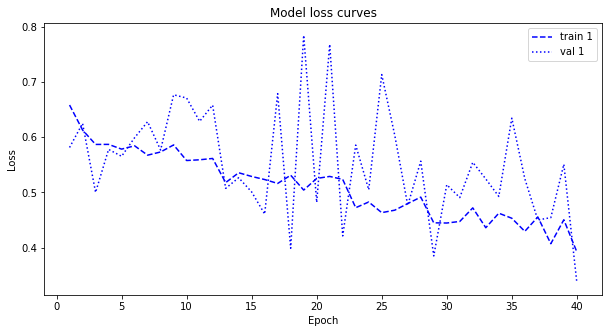

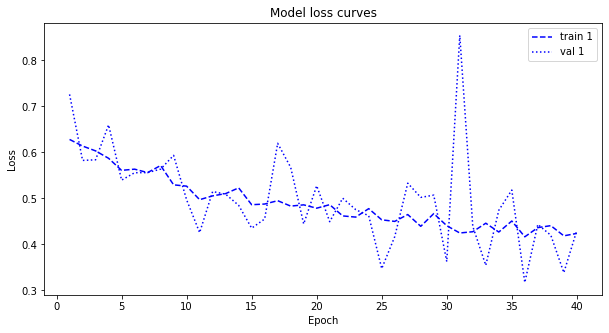

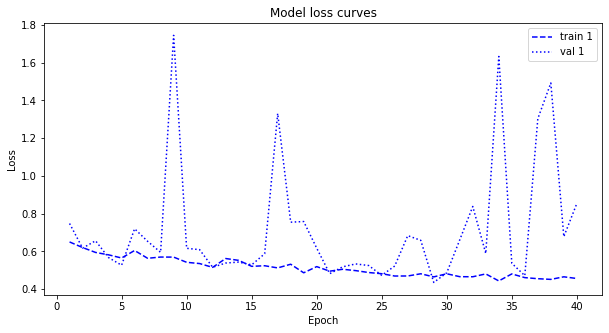

In [81]:
#FOR LOOP VERSION
model_num_list = np.arange(202,205).tolist()
#model_num_list.insert(0,34)
network_name_list = ['densenet201'] * len(model_num_list)
pretrained_list = ['pretrained'] * 1
pretrained_list.extend(['default'] * 2)
#pretrained_list.extend(pretrained_list)
kernel_list = [3] * 1
kernel_list.extend([5]*2)
epoch_list = [40] * len(model_num_list)
lr_list = [0.0005,0.0001] * 2

print(len(model_num_list))
print(len(network_name_list))
print(len(pretrained_list))
print(len(kernel_list))
print(len(epoch_list))
print(len(lr_list))


TP_list, FP_list, FN_list, TN_list = [], [], [], []
accuracy_list, sensitivity_list, specificity_list = [], [], []
for ii in range(0,len(model_num_list)):
    model_num = model_num_list[ii]
    model_architecture_txt = f'{network_name_list[ii]}_{pretrained_list[ii]}_k{kernel_list[ii]}'
    num_epochs = epoch_list[ii]
    lr = lr_list[ii]
    
    filename_model_trained = filepath_models+f'/{model_num:02}_model_trained.pth'
    filename_loss_fig = filepath_models+f'/{model_num:02}_model_train_losses.png'
    filename_train_val_metrics = filepath_models+f'/{model_num:02}_model_performance_metrics.h5'
    print(filename_model_trained)
    print(filename_train_val_metrics)

    filename_model_network = filepath_models+f'/model_{model_architecture_txt}.pth'
    #Loading the model from the path
    model = th.load(filename_model_network, map_location=th.device(torch_device))
    print('loaded model - ', filename_model_network)
    train_loss_over_epochs, val_loss_over_epochs = [], []
    
    #Loss Function and Optimizer
    loss_fn = th.nn.BCELoss()
    optimizer = th.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), 
                              eps=1e-08, weight_decay=0, amsgrad=False)
    print('epochs= ',num_epochs)
    print('lr= ',lr)
    
    model, train_loss_over_epochs, val_loss_over_epochs = train_network(model,num_epochs,optimizer,loss_fn,train_loader,val_loader)

    fig = plot_losses([train_loss_over_epochs],[val_loss_over_epochs])
    fig.savefig(filename_loss_fig)

    hf = h5py.File(filename_train_val_metrics, 'w')
    hf.create_dataset('train_loss_over_epoch', data=train_loss_over_epochs)
    hf.create_dataset('val_loss_over_epochs', data=val_loss_over_epochs)
    hf.close()
    print('saved train and validation losses - ',filename_train_val_metrics)

    # Save the model
    th.save(model, filename_model_trained) #second argument is the full filepath (.pth file)
    print('saved model after training - ', filename_model_trained)
    
    TP,FP,FN,TN, TP_cases,FP_cases,FN_cases,TN_cases, accuracy,sensitivity,specificity = evaluation(model, val_loader)
    
    TP_list.append(TP)
    FP_list.append(FP)
    FN_list.append(FN)
    TN_list.append(TN)
    accuracy_list.append(f'{accuracy:.4f}')
    sensitivity_list.append(f'{sensitivity:.4f}')
    specificity_list.append(f'{specificity:.4f}')

    filename_tmp_metrics = filepath_models+f'/model_trained_metrics.csv'
    df_tmp_metrics = pd.DataFrame()
    df_tmp_metrics['model_num'] = model_num_list[7:ii+1]
    df_tmp_metrics['architecture'] = network_name_list[7:ii+1]
    df_tmp_metrics['pretrained?'] = pretrained_list[7:ii+1]
    df_tmp_metrics['kernel'] = kernel_list[7:ii+1]
    df_tmp_metrics['lr'] = lr_list[7:ii+1]
    df_tmp_metrics['epochs'] = epoch_list[7:ii+1]
    df_tmp_metrics['TP'] = TP_list
    df_tmp_metrics['FP'] = FP_list
    df_tmp_metrics['FN'] = FN_list
    df_tmp_metrics['TN'] = TN_list
    df_tmp_metrics['val accuracy'] = accuracy_list
    df_tmp_metrics['val sensitivity'] = sensitivity_list
    df_tmp_metrics['val specificiy'] = specificity_list
    df_tmp_metrics.to_csv(filename_tmp_metrics)

In [55]:
TP_list

[]

/data/VirtualAging/users/mwtong/FaceBoneGender/models/206_model_trained.pth
/data/VirtualAging/users/mwtong/FaceBoneGender/models/206_model_performance_metrics.h5
loaded model -  /data/VirtualAging/users/mwtong/FaceBoneGender/models/model_densenet201_pretrained_k3.pth
40
0.0005
training network
epoch: 0, train loss: 0.6025, validation loss: 0.7512, runtime: 0m 15s
epoch: 1, train loss: 0.5261, validation loss: 0.5956, runtime: 0m 30s
epoch: 2, train loss: 0.5420, validation loss: 0.4694, runtime: 0m 45s
epoch: 3, train loss: 0.4969, validation loss: 4.0167, runtime: 0m 59s
epoch: 4, train loss: 0.5002, validation loss: 1.2202, runtime: 1m 14s
epoch: 5, train loss: 0.4744, validation loss: 0.4696, runtime: 1m 29s
epoch: 6, train loss: 0.4457, validation loss: 1.7018, runtime: 1m 44s
epoch: 7, train loss: 0.4196, validation loss: 0.6946, runtime: 1m 59s
epoch: 8, train loss: 0.5361, validation loss: 0.5679, runtime: 2m 14s
epoch: 9, train loss: 0.5312, validation loss: 0.6258, runtime: 2

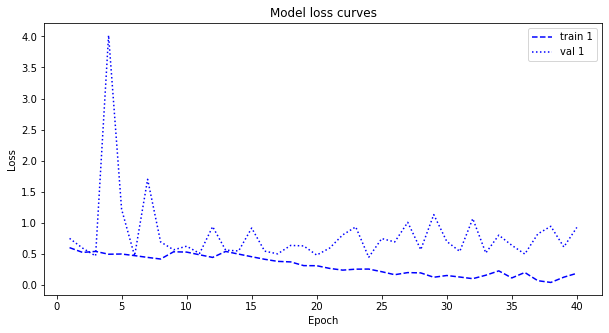

In [108]:
#1 PARAM SET VERSION
#---TODO: Define model parameters---
#SPECIFY the model_num = choose any number 1-99 to save the model after it has been trained with this parameter set
model_num = 206 #CHANGE
#VARY the num_epochs and lr so that the loss plot looks good
num_epochs = 40
lr = 0.0005
#VARY model_architure_txt = specify the model we load (this will vary the network, pre-trained, and kernel size)
model_architecture_txt = 'densenet201_pretrained_k3' #CHANGE
#-----------------------------------

filename_model_trained = filepath_models+f'/{model_num:02}_model_trained.pth'
filename_loss_fig = filepath_models+f'/{model_num:02}_model_train_losses.png'
filename_train_val_metrics = filepath_models+f'/{model_num:02}_model_performance_metrics.h5'
print(filename_model_trained)
print(filename_train_val_metrics)

filename_model_network = filepath_models+f'/model_{model_architecture_txt}.pth'
#Loading the model from the path
model = th.load(filename_model_network, map_location=th.device(torch_device))
print('loaded model - ', filename_model_network)

#Loss Function and Optimizer
loss_fn = th.nn.BCELoss()
optimizer = th.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), 
                          eps=1e-08, weight_decay=0, amsgrad=False)
print(num_epochs)
print(lr)

model, train_loss_over_epochs, val_loss_over_epochs = train_network(model,num_epochs,optimizer,loss_fn,train_loader,val_loader)

fig = plot_losses([train_loss_over_epochs],[val_loss_over_epochs])
fig.savefig(filename_loss_fig)

hf = h5py.File(filename_train_val_metrics, 'w')
hf.create_dataset('train_loss_over_epoch', data=train_loss_over_epochs)
hf.create_dataset('val_loss_over_epochs', data=val_loss_over_epochs)
hf.close()
print('saved train and validation losses - ',filename_train_val_metrics)

# Save the model
th.save(model, filename_model_trained) #second argument is the full filepath (.pth file)
print('saved model after training - ', filename_model_trained)

In [15]:

'''
hf = h5py.File(filename_train_val_metrics, 'r')
filename_train_val_metrics
train_loss_over_epoch = hf.get('train_loss_over_epochs')
val_loss_over_epochs = hf.get('val_loss_over_epochs')
'''


"\nhf = h5py.File(filename_train_val_metrics, 'r')\nfilename_train_val_metrics\ntrain_loss_over_epoch = hf.get('train_loss_over_epochs')\nval_loss_over_epochs = hf.get('val_loss_over_epochs')\n"

# 4.1 Model evaluation (val dataset)

In [96]:
def test_network(model, data_loader):
    labels_list = []
    preds_list = []
    file_nums_list = []
    
    model.eval()
    # since we're not training, we don't need to calculate the gradients for our outputs
    with th.no_grad():
        for data in data_loader:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels, file_nums = data
            inputs = inputs.to(torch_device)

            # forward
            preds = model(inputs)[:, 0:1].float()

            for batch_idx in range(len(labels)):
                label = labels[batch_idx].detach().cpu().numpy()
                pred = preds[batch_idx].detach().cpu().numpy()
                file_num = file_nums[batch_idx].detach().cpu().numpy()
                
                labels_list.extend(label)
                preds_list.extend(pred)
                file_nums_list.append(file_num)

    return labels_list, preds_list, file_nums_list
                
        
def evaluation(model, data_loader):
    #dataloader should be val_loader or test_loader
    """Computes acccuracy and the confusiuon matrix of the model based on dataset_test
    Returns accuracy, TP, FP, FN, TN """
    
    labels, preds, file_nums = test_network(model, data_loader)
    
    #Confusion Matrix Metrics
    TP, FP, FN, TN = 0, 0, 0, 0
    TP_cases, FP_cases, FN_cases, TN_cases = [], [], [], []
    
    for ii in range(len(labels)):
        label = labels[ii]
        pred = preds[ii]
        file_num = file_nums[ii]

        #Checking for 
        if (pred >= 0.5 and label == 1): 
            TP += 1 
            TP_cases.append(file_num)
        if (pred >= 0.5 and label == 0):
            FP += 1
            FP_cases.append(file_num)
        if (pred < 0.5 and label == 1):
            FN += 1
            FN_cases.append(file_num)
        if (pred < 0.5 and label == 0):
            TN += 1
            TN_cases.append(file_num)
            
    accuracy = (TP + TN)/len(labels) # correct/total
    sensitivity = TP/(TP+FN) 
    specificity = TN/(TN+FP) 
    
    return TP,FP,FN,TN, TP_cases,FP_cases,FN_cases,TN_cases, accuracy,sensitivity,specificity

#FOR LOOP VERSION
#model_num_list = [1,3,13,14,15,5,20,2,4,10,11,12,6,19]
model_num_list = [28,24,25,21,7,29,18,16,26,27,23,8,9,17,22]

TP_list = []
FP_list = []
FN_list = []
TN_list = []
accuracy_list = []
sensitivity_list = []
specificity_list = []
for ii in range(len(model_num_list)):
    
    
    model_num = model_num_list[ii]
    
    filename_model_trained = filepath_models+f'/{model_num:02}_model_trained.pth'
    filename_train_val_metrics = filepath_models+f'/{model_num:02}_model_performance_metrics.h5'

    # Load trained model
    model = th.load(filename_model_trained, map_location=th.device(torch_device))
    print('loaded model - ', filename_model_trained)
    
    TP,FP,FN,TN, TP_cases,FP_cases,FN_cases,TN_cases, accuracy,sensitivity,specificity = evaluation(model, val_loader)
    
    TP_list.append(TP)
    FP_list.append(FP)
    FN_list.append(FN)
    TN_list.append(TN)
    accuracy_list.append(f'{accuracy:.4f}')
    sensitivity_list.append(f'{sensitivity:.4f}')
    specificity_list.append(f'{specificity:.4f}')
    print(accuracy, sensitivity, specificity)

filename_tmp_metrics = filepath_models+f'/model_trained_metrics.csv'
df_tmp_metrics = pd.DataFrame()
df_tmp_metrics['model_num'] = model_num_list 
'''
df_tmp_metrics['architecture'] = 
df_tmp_metrics['pretrained?'] = 
df_tmp_metrics['kernel'] = 
df_tmp_metrics['lr'] = 
df_tmp_metrics['epochs'] = 
'''
df_tmp_metrics['TP'] = TP_list
df_tmp_metrics['FP'] = FP_list
df_tmp_metrics['FN'] = FN_list
df_tmp_metrics['TN'] = TN_list
df_tmp_metrics['val accuracy'] = accuracy_list
df_tmp_metrics['val sensitivity'] = sensitivity_list
df_tmp_metrics['val specificiy'] = specificity_list
df_tmp_metrics.to_csv(filename_tmp_metrics)

In [17]:
#1 PARAM SET VERSION
model_num = 31
filename_model_trained = filepath_models+f'/{model_num:02}_model_trained.pth'
filename_loss_fig = filepath_models+f'/{model_num:02}_model_train_losses.png'
filename_train_val_metrics = filepath_models+f'/{model_num:02}_model_performance_metrics.h5'

# Load trained model
model = th.load(filename_model_trained, map_location=th.device(torch_device))
print('loaded model - ', filename_model_trained)

loaded model -  /data/VirtualAging/users/mwtong/FaceBoneGender/models/31_model_trained.pth


In [97]:
TP,FP,FN,TN, TP_cases,FP_cases,FN_cases,TN_cases, accuracy,sensitivity,specificity = evaluation(model, val_loader)

n_cases = len(test_loader)
print(f'accuracy: {accuracy*100:.2f}')
print(f'sensitivity: {sensitivity*100:.2f}')
print(f'specificity: {specificity*100:.2f}')
print()
print('confusion matrix')
print(f'-------------------------------------')
print(f'TP: {TP: <4} {TP/n_cases: <8.2%}| FP: {FP: <4} {FP/n_cases: <8.2%}| predicted female (1): {TP+FP}')
print(f'FN: {FN: <4} {FN/n_cases: <8.2%}| TN: {TN: <4} {TN/n_cases: <8.2%}| predicted male (0): {FN+TN}')
print(f'-------------------------------------')
print(f'actual F: {TP+FN}     | actual M: {FP+TN}')
print()

hf = h5py.File(filename_train_val_metrics, 'a')
hf.create_dataset('accuracy', data=accuracy)
hf.create_dataset('sensitivity', data=sensitivity)
hf.create_dataset('specificity', data=specificity)
hf.create_dataset('true_F_filenum', data=TP_cases)
hf.create_dataset('false_F_filenum', data=FP_cases)
hf.create_dataset('true_M_filenum', data=TN_cases)
hf.create_dataset('false_M_filenum', data=FN_cases)
hf.close()
print('updated performance - ',filename_train_val_metrics)


accuracy: 68.63
sensitivity: 59.26
specificity: 72.00

confusion matrix
-------------------------------------
TP: 16   15.38%  | FP: 21   20.19%  | predicted female (1): 37
FN: 11   10.58%  | TN: 54   51.92%  | predicted male (0): 65
-------------------------------------
actual F: 27     | actual M: 75

updated performance -  /data/VirtualAging/users/mwtong/FaceBoneGender/models/205_model_performance_metrics.h5


In [63]:
hf.close()

figure of files  [array(1346), array(227), array(1305)]
figure of files  [array(660), array(1179), array(1125)]
figure of files  [array(655), array(189), array(373)]
figure of files  [array(907), array(962), array(1068)]


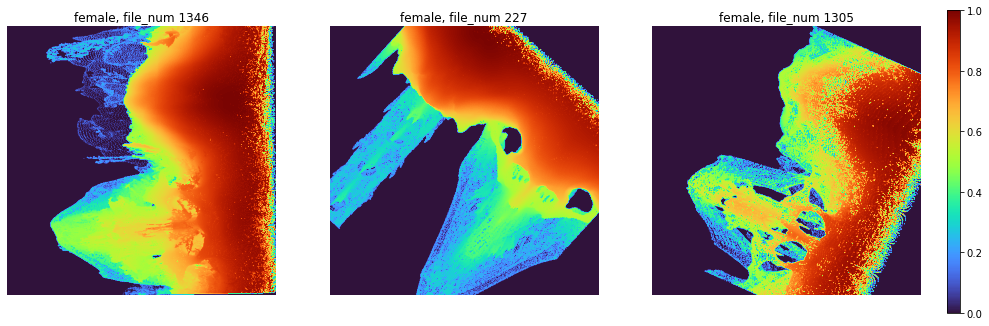

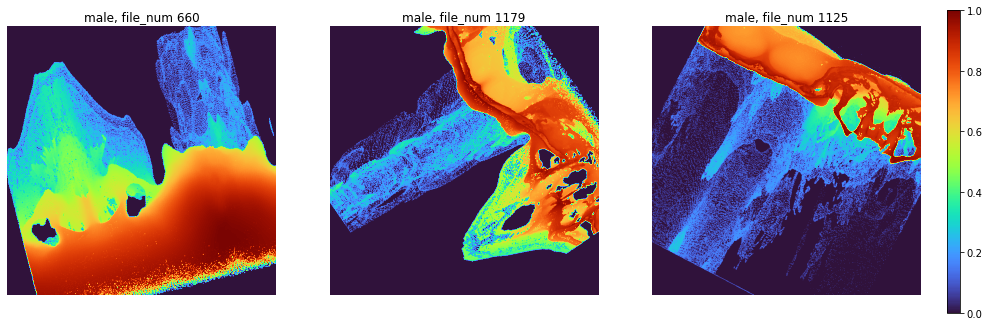

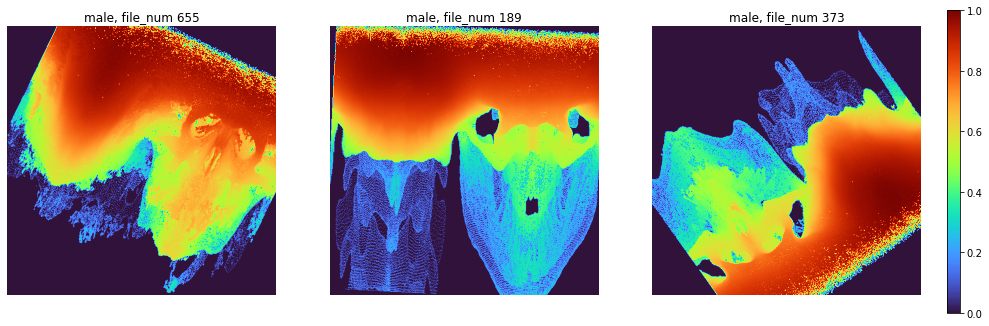

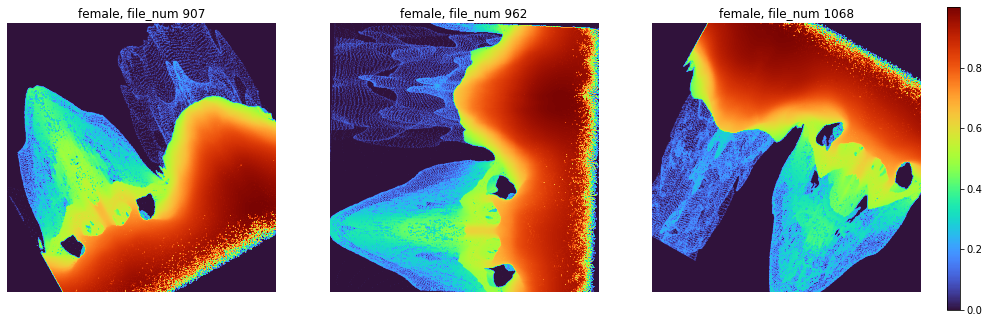

In [98]:
#Visualize images
#specify the file number for the image, ie. 2 for 0002.mat
img_num_list = TP_cases[0:min(3,len(TP_cases))]
plot_images(img_num_list,dataset)

img_num_list = FP_cases[0:min(3,len(FP_cases))]
plot_images(img_num_list,dataset)

img_num_list = TN_cases[0:min(3,len(TN_cases))]
plot_images(img_num_list,dataset)

img_num_list = FN_cases[0:min(3,len(FN_cases))]
plot_images(img_num_list,dataset)

# 4.2 Model evaluation (test dataset)

In [79]:
dataset_test_no_transforms = face_img_dataloader(df_data_info.iloc[test_indices].reset_index(drop=True),filepath_data, transform=None)
test_loader_no_transforms = th.utils.data.DataLoader(dataset_test_no_transforms, batch_size=1, shuffle = False)

TP,FP,FN,TN, TP_cases,FP_cases,FN_cases,TN_cases, accuracy,sensitivity,specificity = evaluation(model, test_loader_no_transforms)

n_cases = len(test_loader)
print(f'accuracy: {accuracy*100:.2f}')
print()
print('confusion matrix')
print(f'-------------------------------------')
print(f'TP: {TP: <4} {TP/n_cases: <8.2%}| FP: {FP: <4} {FP/n_cases: <8.2%}| predicted female (1): {TP+FP}')
print(f'FN: {FN: <4} {FN/n_cases: <8.2%}| TN: {TN: <4} {TN/n_cases: <8.2%}| predicted male (0): {FN+TN}')
print(f'-------------------------------------')
print(f'actual F: {TP+FN}     | actual M: {FP+TN}')
print()

accuracy: 87.50

confusion matrix
-------------------------------------
TP: 23   22.12%  | FP: 5    4.81%   | predicted female (1): 28
FN: 8    7.69%   | TN: 68   65.38%  | predicted male (0): 76
-------------------------------------
actual F: 31     | actual M: 73



figure of files  [array(966), array(602), array(594)]
figure of files  [array(113), array(503), array(633)]
figure of files  [array(930), array(320), array(345)]
figure of files  [array(932), array(1352), array(254)]


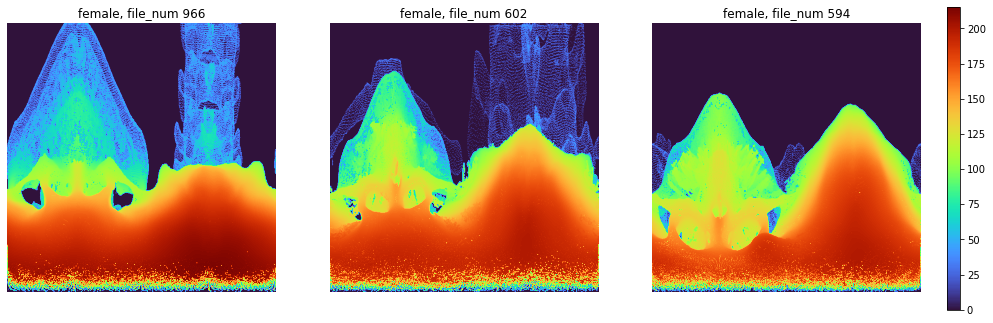

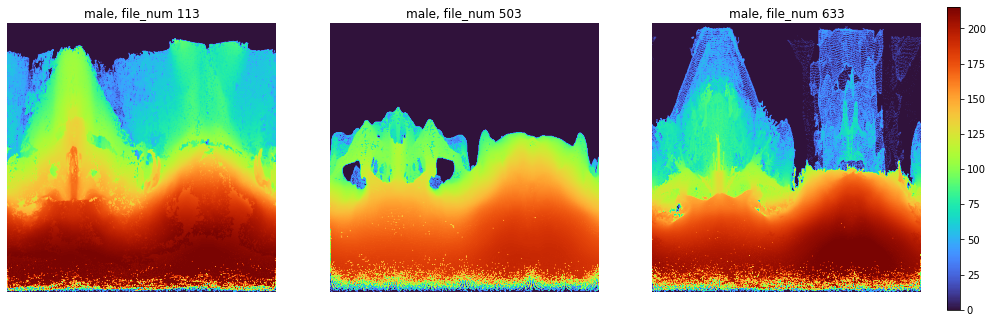

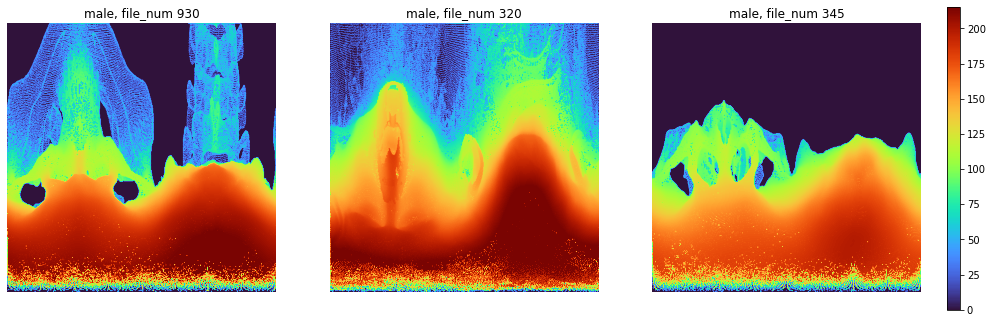

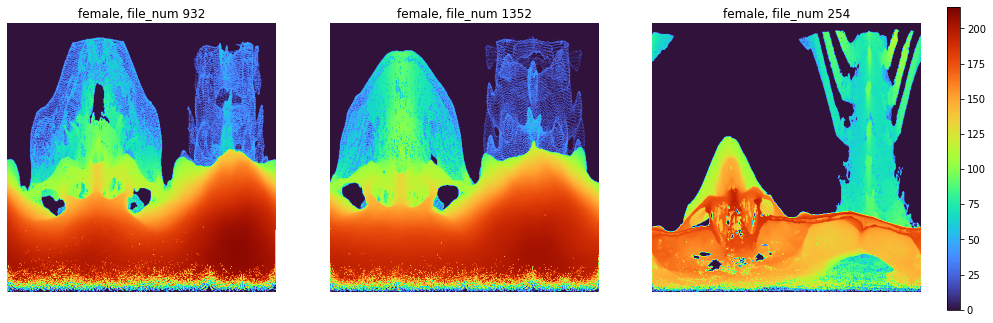

In [80]:
#Visualize images
#specify the file number for the image, ie. 2 for 0002.mat
img_num_list = TP_cases[0:min(3,len(TP_cases))]
plot_images(img_num_list,dataset_test_no_transforms)

img_num_list = FP_cases[0:min(3,len(FP_cases))]
plot_images(img_num_list,dataset_test_no_transforms)

img_num_list = TN_cases[0:min(3,len(TN_cases))]
plot_images(img_num_list,dataset_test_no_transforms)

img_num_list = FN_cases[0:min(3,len(FN_cases))]
plot_images(img_num_list,dataset_test_no_transforms)